## Baseline model

### import thư viện

In [2]:
# import thư viện
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [3]:
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("No CUDA detected.")

CUDA Available: True
CUDA Device Name: NVIDIA RTX A500 Laptop GPU
CUDA Version: 12.4


In [4]:
# download dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

SEED = 42
set_seed(SEED)

In [5]:
# devide data into many train/val/test
train_ratio = 0.9 # tỉ lệ tập train
train_size = int(train_ratio * len(train_dataset)) # số lượng mẫu của tập train
val_size = len(train_dataset) - train_size
train_subdataset, val_subdataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subdataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_Loader = DataLoader(val_subdataset, batch_size=batch_size, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)
print(f'train_size: {len(train_subdataset)}')
print(f'val_size: {len(val_subdataset)}')
print(f'test_size: {len(test_dataset)}')

train_size: 54000
val_size: 6000
test_size: 10000


### Xây dựng mô hình

In [5]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)

  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 0.01
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

### Train mô hình

In [6]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 2.3042, Train_Acc : 0.0996, Validation Loss : 2.3062, Val_Acc :0.0895
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 2.3038, Train_Acc : 0.0983, Validation Loss : 2.3041, Val_Acc :0.0895
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 2.3039, Train_Acc : 0.0962, Validation Loss : 2.3043, Val_Acc :0.1022
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 2.3039, Train_Acc : 0.1007, Validation Loss : 2.3036, Val_Acc :0.1022
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 2.3038, Train_Acc : 0.1009, Validation Loss : 2.3042, Val_Acc :0.1012
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 2.3039, Train_Acc : 0.0989, Validation Loss : 2.3045, Val_Acc :0.1000
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 2.3038, Train_Acc : 0.1006, Validation

Text(0.5, 1.0, 'Validation Accuracy')

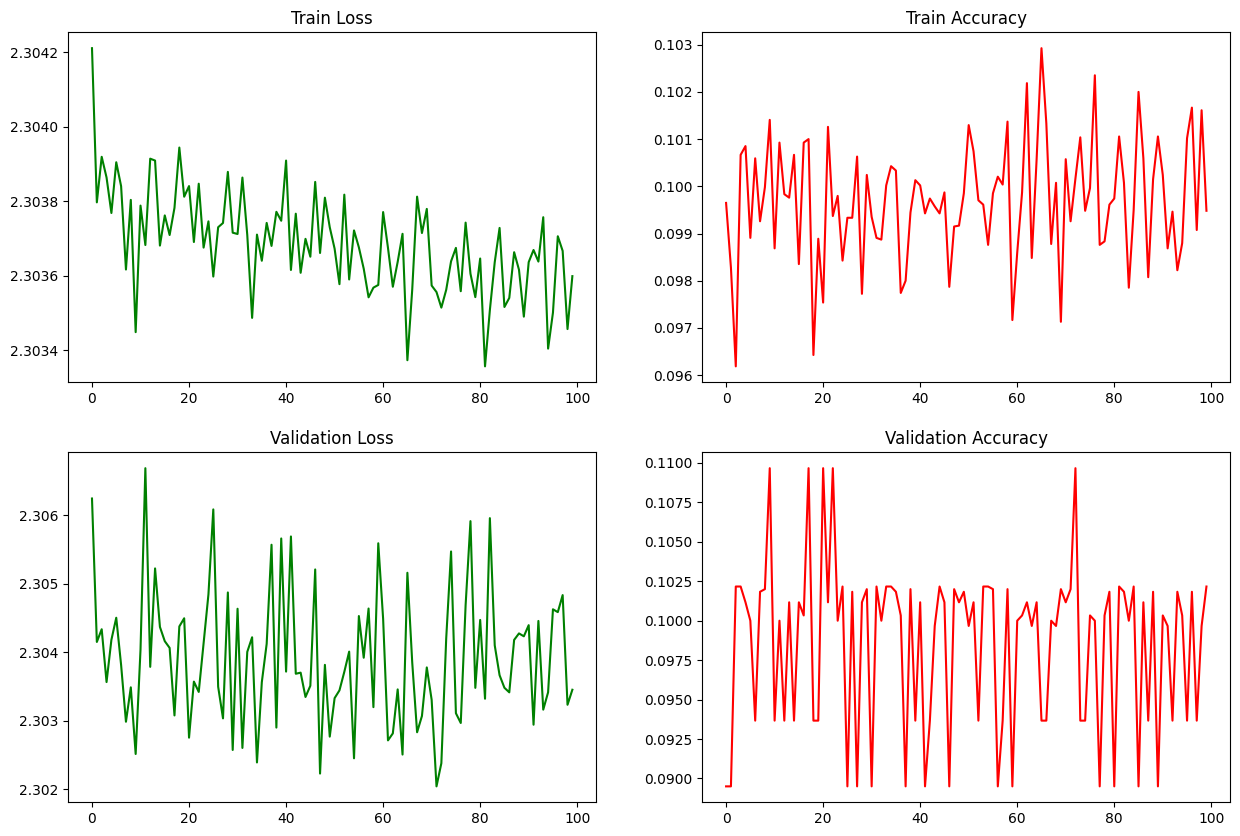

In [8]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Baseline Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Baseline Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Baseline Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Baseline Validation Accuracy')

## Weight Increasing

### Xây dựng mô hình: std = 1

In [10]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=1)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 0.01
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

### Train mô hình

In [ ]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


Text(0.5, 1.0, 'Validation Accuracy')

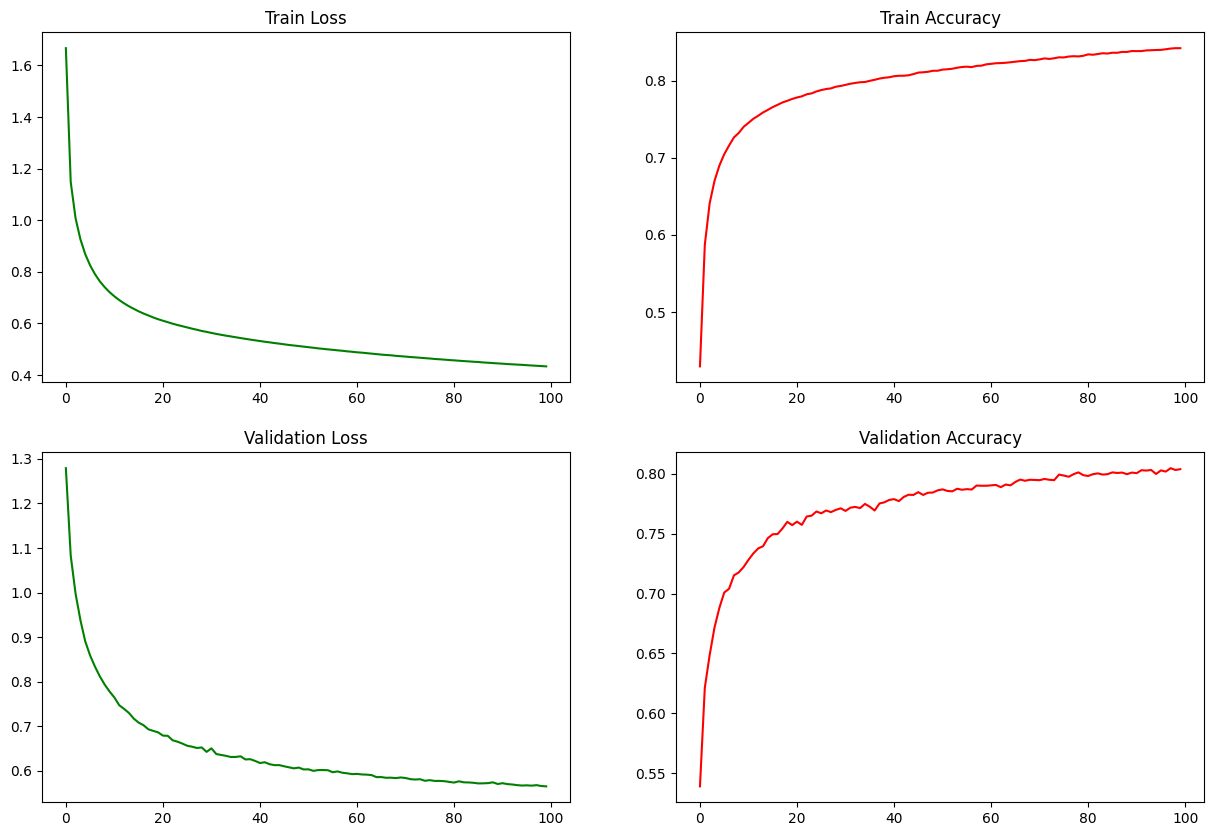

In [12]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Weight_inceasing_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Weight_inceasing_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Weight_inceasing_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Weight_inceasing_Validation Accuracy')

### Xây dựng mô hình: std = 10

In [14]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=10)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 0.01
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

### Train mô hình

In [15]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 50.1829, Train_Acc : 0.1016, Validation Loss : 24.4364, Val_Acc :0.0927
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 19.1722, Train_Acc : 0.1099, Validation Loss : 9.8402, Val_Acc :0.1323
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 5.1194, Train_Acc : 0.1101, Validation Loss : 3.9007, Val_Acc :0.1325
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 3.7905, Train_Acc : 0.1129, Validation Loss : 5.2560, Val_Acc :0.1393
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 3.5138, Train_Acc : 0.1158, Validation Loss : 2.9874, Val_Acc :0.1112
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 2.7938, Train_Acc : 0.1111, Validation Loss : 2.7299, Val_Acc :0.1007
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 2.6126, Train_Acc : 0.1106, Validat

Text(0.5, 1.0, 'Validation Accuracy')

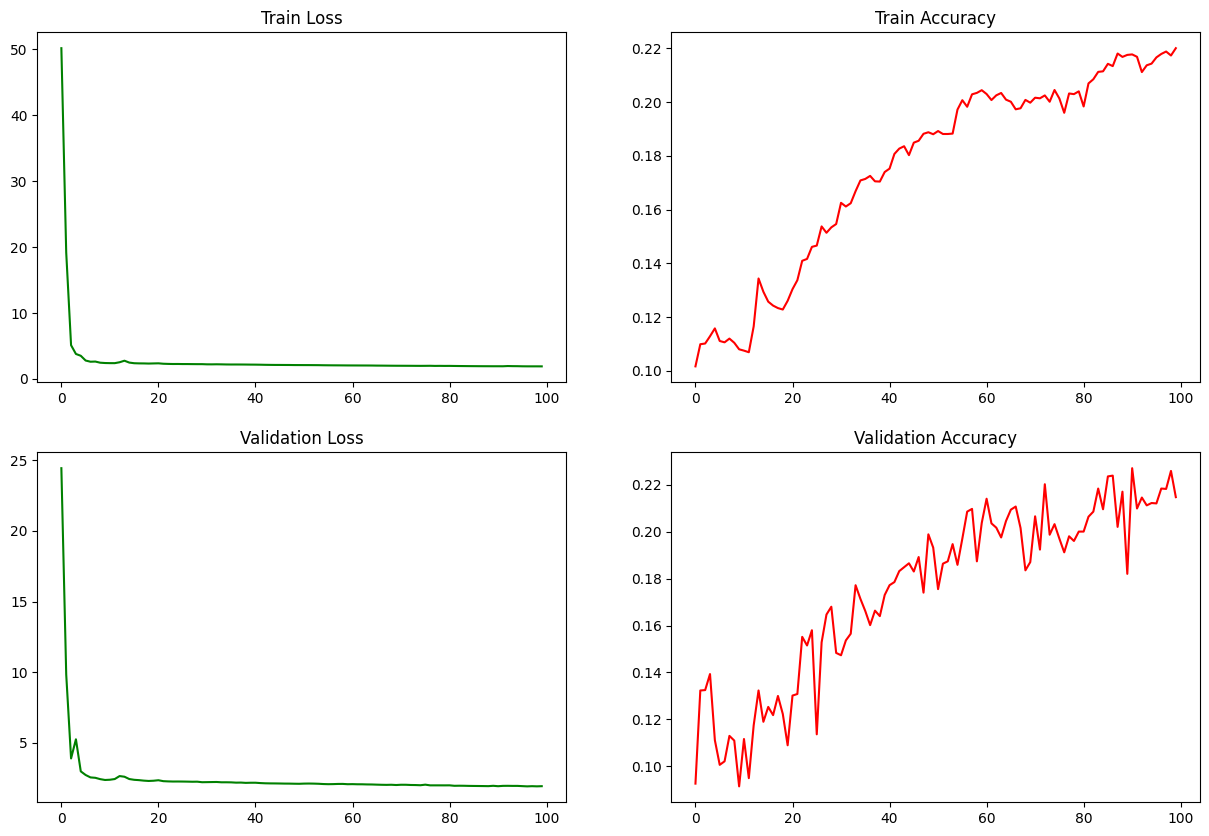

In [16]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Weight_inceasing2_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Weight_inceasing2_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Weight_inceasing2_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Weight_inceasing2_Validation Accuracy')

## Better Activation

### Xây dựng mô hình

In [17]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.05)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = nn.ReLU()(x)
    x = self.layer2(x)
    x = nn.ReLU()(x)
    x = self.layer3(x)
    x = nn.ReLU()(x)
    x = self.layer4(x)
    x = nn.ReLU()(x)
    x = self.layer5(x)
    x = nn.ReLU()(x)
    x = self.layer6(x)
    x = nn.ReLU()(x)
    x = self.layer7(x)
    x = nn.ReLU()(x)
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 0.01
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

### Train mô hình

In [ ]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


Text(0.5, 1.0, 'Validation Accuracy')

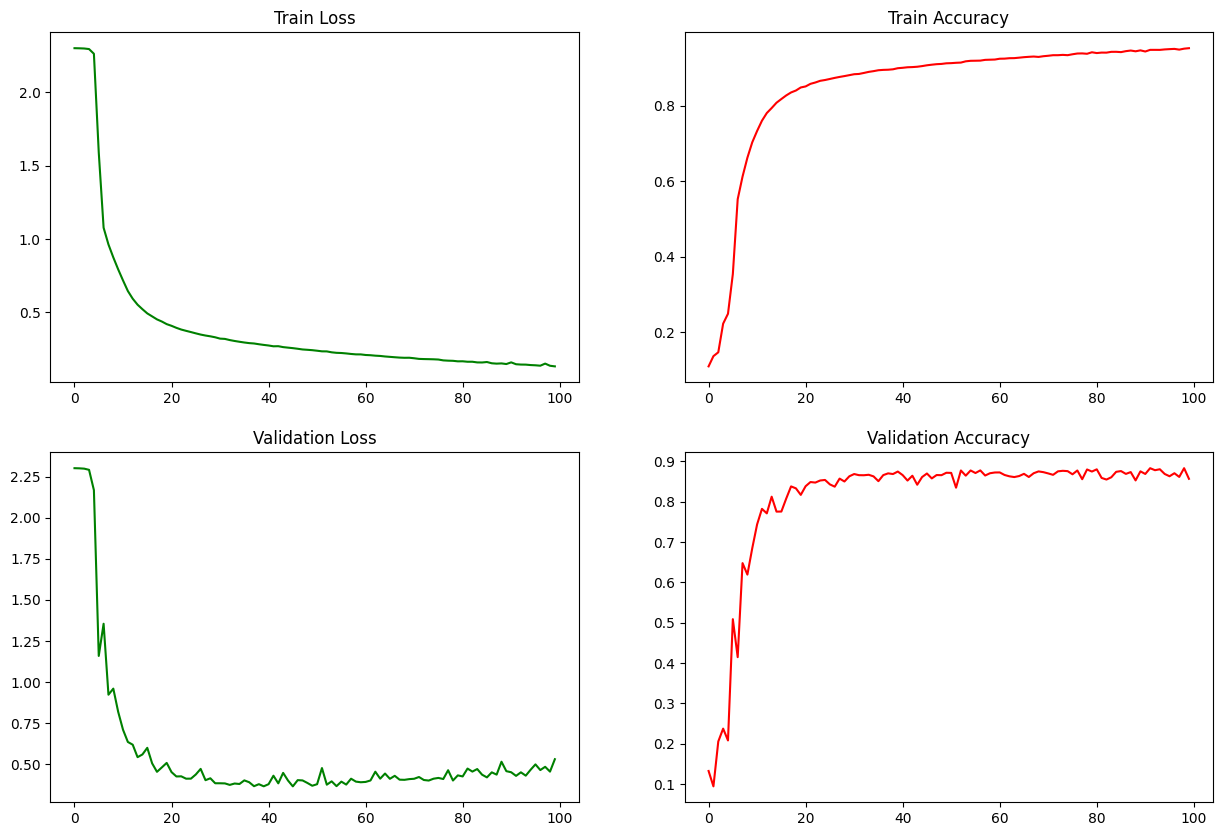

In [19]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Beter_Activation_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Beter_Activation_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Beter_Activation_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Beter_Activation_Validation Accuracy')

## Better Optimizater

### Xây dựng mô hình

In [23]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.05)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = nn.ReLU()(x)
    x = self.layer2(x)
    x = nn.ReLU()(x)
    x = self.layer3(x)
    x = nn.ReLU()(x)
    x = self.layer4(x)
    x = nn.ReLU()(x)
    x = self.layer5(x)
    x = nn.ReLU()(x)
    x = self.layer6(x)
    x = nn.ReLU()(x)
    x = self.layer7(x)
    x = nn.ReLU()(x)
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 1e-3
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)

### Train mô hình với ADAM optimizer

In [ ]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


Text(0.5, 1.0, 'Validation Accuracy')

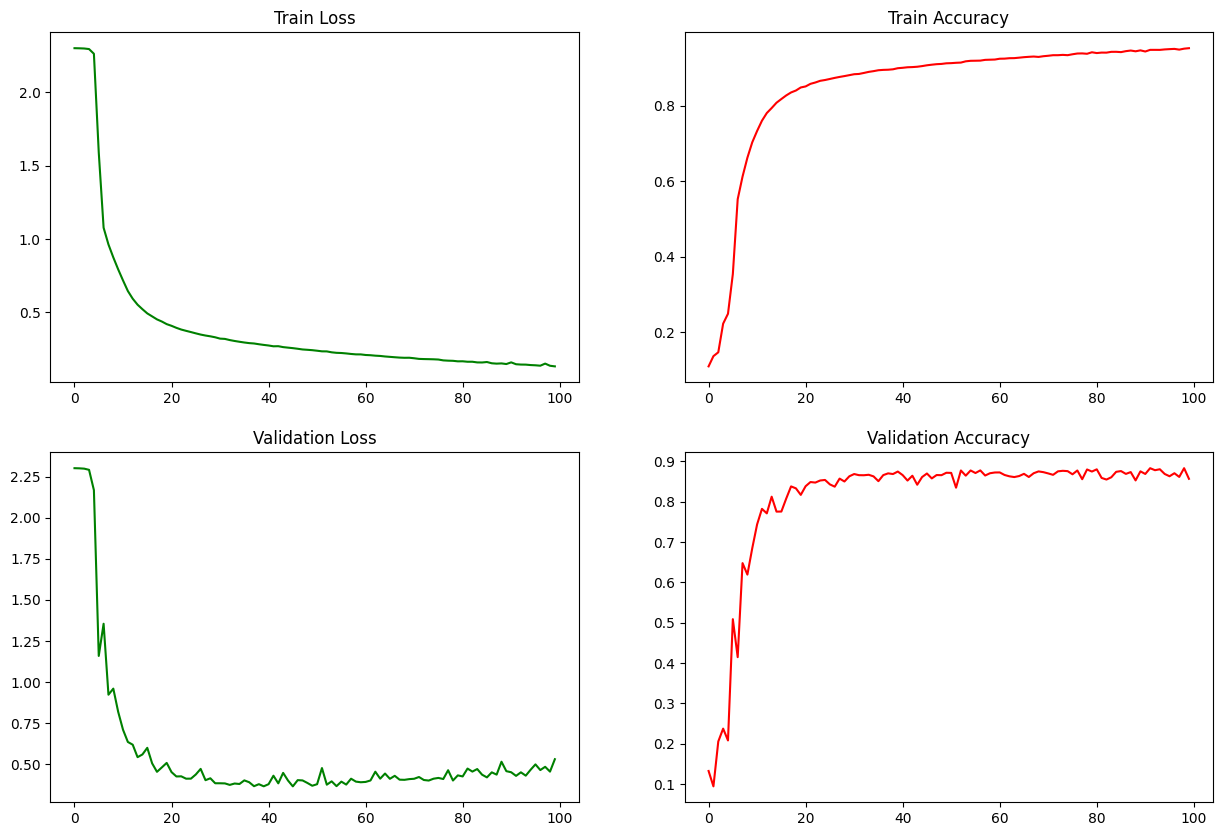

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Beter_optimizer_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Beter_optimizer_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Beter_optimizer_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Beter_optimizer_Validation Accuracy')

## Batch Normalization

### Xây dựng mô hình

In [39]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.bn1 = nn.BatchNorm1d(hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.bn2 = nn.BatchNorm1d(hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.bn3 = nn.BatchNorm1d(hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.bn4 = nn.BatchNorm1d(hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.bn5 = nn.BatchNorm1d(hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.bn6 = nn.BatchNorm1d(hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.bn7 = nn.BatchNorm1d(hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.05)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = self.bn1(x)
    x = nn.Sigmoid()(x)

    x = self.layer2(x)
    x = self.bn2(x)
    x = nn.Sigmoid()(x)

    x = self.layer3(x)
    x = self.bn3(x)
    x = nn.Sigmoid()(x)

    x = self.layer4(x)
    x = self.bn4(x)
    x = nn.Sigmoid()(x)

    x = self.layer5(x)
    x = self.bn5(x)
    x = nn.Sigmoid()(x)

    x = self.layer6(x)
    x = self.bn6(x)
    x = nn.Sigmoid()(x)

    x = self.layer7(x)
    x = self.bn7(x)
    x = nn.Sigmoid()(x)
    
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 1e-3
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)

### Train mô hình với ADAM optimizer

In [40]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 0.6416, Train_Acc : 0.8136, Validation Loss : 0.5176, Val_Acc :0.8092
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 0.4312, Train_Acc : 0.8474, Validation Loss : 0.4103, Val_Acc :0.8562
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 0.4003, Train_Acc : 0.8571, Validation Loss : 0.3987, Val_Acc :0.8602
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 0.3767, Train_Acc : 0.8643, Validation Loss : 0.4042, Val_Acc :0.8552
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 0.3569, Train_Acc : 0.8705, Validation Loss : 0.3677, Val_Acc :0.8703
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 0.3436, Train_Acc : 0.8744, Validation Loss : 0.3729, Val_Acc :0.8707
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 0.3281, Train_Acc : 0.8794, Validation

Text(0.5, 1.0, 'Validation Accuracy')

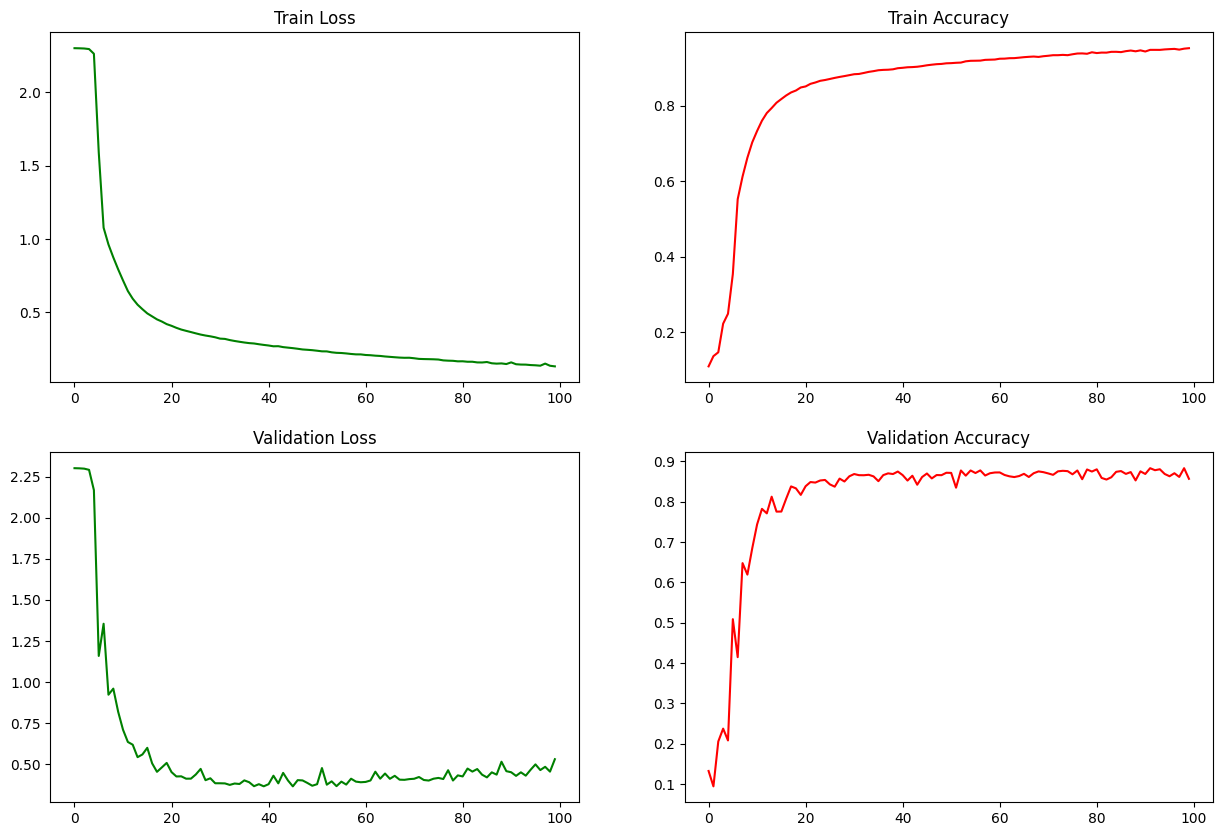

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Batch_norm_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Batch_norm_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Batch_norm_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Batch_norm_Validation Accuracy')

## Customized batch normalization

In [42]:
class MyNormalization(nn.Module):
    def __init__(self):
        super(MyNormalization, self).__init__()

    def forward(self, x):
        # Tính mean và std trên batch
        mean = torch.mean(x, dim=0, keepdim=True)
        std = torch.std(x, dim=0, keepdim=True)
        # Chuẩn hóa dữ liệu
        return (x - mean) / (std + 1e-6)  # Thêm epsilon để tránh chia cho 0

In [43]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.bn1 = MyNormalization()
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.bn2 = MyNormalization()
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.bn3 = MyNormalization()
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.bn4 = MyNormalization()
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.bn5 = MyNormalization()
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.bn6 = MyNormalization()
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.bn7 = MyNormalization()
    self.output = nn.Linear(hidden_dims, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.05)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = self.bn1(x)
    x = nn.Sigmoid()(x)

    x = self.layer2(x)
    x = self.bn2(x)
    x = nn.Sigmoid()(x)

    x = self.layer3(x)
    x = self.bn3(x)
    x = nn.Sigmoid()(x)

    x = self.layer4(x)
    x = self.bn4(x)
    x = nn.Sigmoid()(x)

    x = self.layer5(x)
    x = self.bn5(x)
    x = nn.Sigmoid()(x)

    x = self.layer6(x)
    x = self.bn6(x)
    x = nn.Sigmoid()(x)

    x = self.layer7(x)
    x = self.bn7(x)
    x = nn.Sigmoid()(x)
    
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 1e-3
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)

In [44]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 0.6857, Train_Acc : 0.8096, Validation Loss : 0.5052, Val_Acc :0.8363
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 0.4527, Train_Acc : 0.8449, Validation Loss : 0.4627, Val_Acc :0.8443
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 0.4172, Train_Acc : 0.8532, Validation Loss : 0.4389, Val_Acc :0.8467
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 0.3952, Train_Acc : 0.8597, Validation Loss : 0.4216, Val_Acc :0.8533
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 0.3805, Train_Acc : 0.8650, Validation Loss : 0.4245, Val_Acc :0.8507
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 0.3668, Train_Acc : 0.8688, Validation Loss : 0.4347, Val_Acc :0.8457
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 0.3551, Train_Acc : 0.8724, Validation

Text(0.5, 1.0, 'Validation Accuracy')

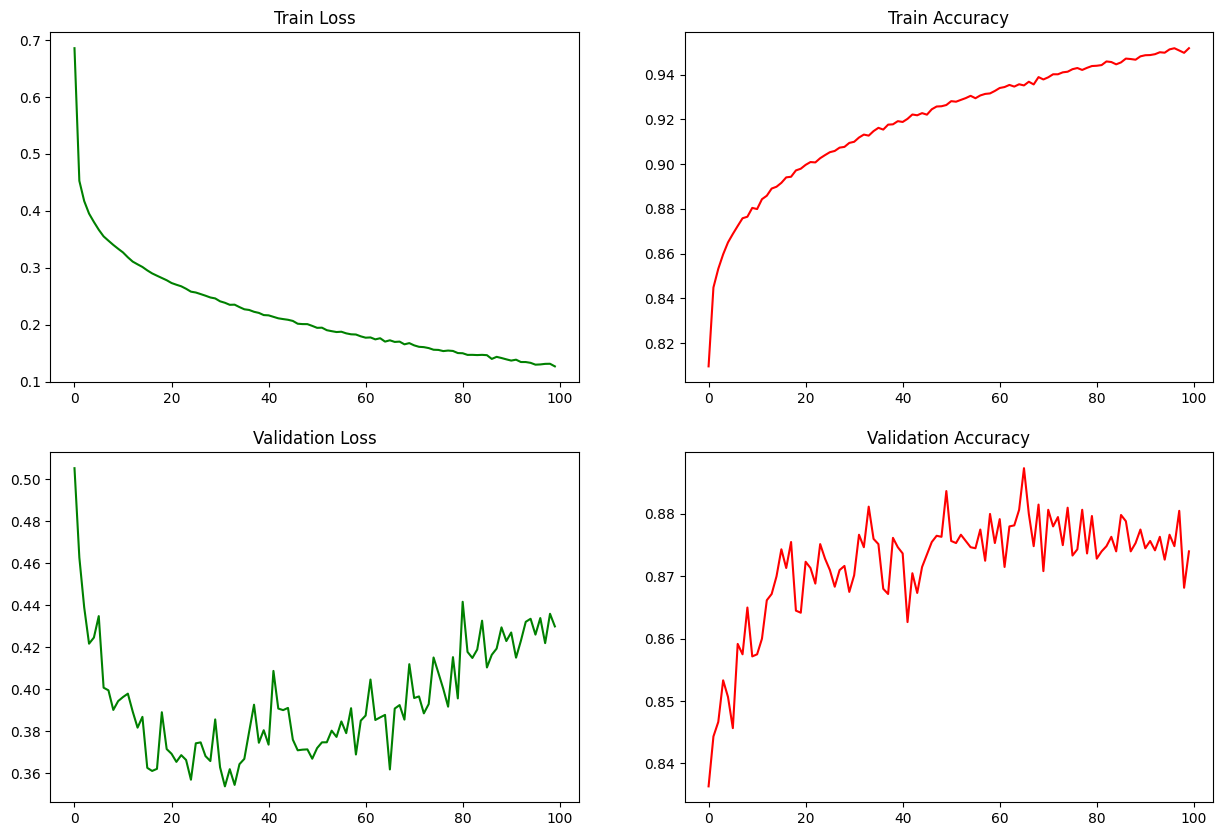

In [45]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('C_Batch_norm_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('C_Batch_norm_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('C_Batch_norm_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('C_Batch_norm_Validation Accuracy')

## Skip Connection 

### Xây dựng mô hình

In [7]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.05)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    skip = x

    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = skip + x

    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    skip = x

    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    x = skip + x
    
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 1e-3
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)

### Train mô hình với ADAM optimizer

In [8]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 0.8428, Train_Acc : 0.6945, Validation Loss : 0.5363, Val_Acc :0.8097
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 0.4639, Train_Acc : 0.8330, Validation Loss : 0.4576, Val_Acc :0.8385
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 0.3979, Train_Acc : 0.8570, Validation Loss : 0.4005, Val_Acc :0.8567
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 0.3618, Train_Acc : 0.8691, Validation Loss : 0.3942, Val_Acc :0.8588
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 0.3386, Train_Acc : 0.8779, Validation Loss : 0.3549, Val_Acc :0.8725
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 0.3216, Train_Acc : 0.8836, Validation Loss : 0.3643, Val_Acc :0.8707
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 0.3090, Train_Acc : 0.8868, Validation

Text(0.5, 1.0, 'Validation Accuracy')

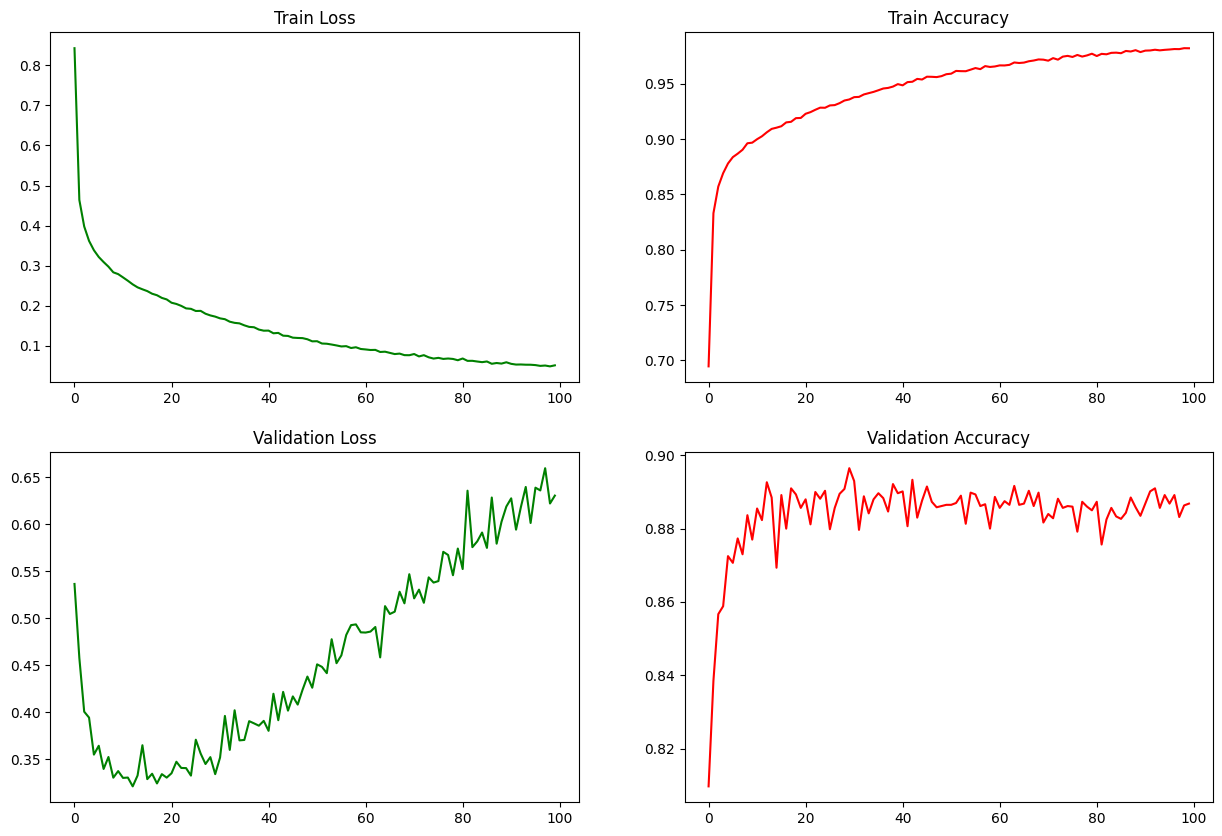

In [9]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Skip_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Skip_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Skip_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Skip_Validation Accuracy')

## Train layers separately (fine-tuning)

### Xây dựng mô hình

In [6]:
class MLP1layer(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP1layer, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.05)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    out = nn.Sigmoid()(x)
    return out
  

class MLP2layers(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP2layers, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)
    self.layer2 = nn.Linear(output_dims, output_dims)

  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = nn.Sigmoid()(x)

    x = self.layer2(x)
    out = nn.Sigmoid()(x)
    return out




input_dims = 28*28
output_dims = 128
num_classes = 10
lr = 1e-2

In [7]:
First = MLP2layers(input_dims=input_dims, output_dims=output_dims)
Second = MLP2layers(input_dims=output_dims, output_dims=output_dims)
Third = MLP2layers(input_dims=output_dims, output_dims=output_dims)
Forth = MLP1layer(input_dims=output_dims, output_dims=output_dims)

### Train mô hình với lớp đầu tiên

In [7]:
model = nn.Sequential(
    First,
    nn.Linear(output_dims, num_classes)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0)

In [8]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 2.2969, Train_Acc : 0.1278, Validation Loss : 2.2890, Val_Acc :0.0997
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 2.2777, Train_Acc : 0.2014, Validation Loss : 2.2611, Val_Acc :0.2780
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 2.2265, Train_Acc : 0.3230, Validation Loss : 2.1724, Val_Acc :0.4742
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 2.0459, Train_Acc : 0.4114, Validation Loss : 1.8834, Val_Acc :0.3915
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 1.7056, Train_Acc : 0.4590, Validation Loss : 1.5655, Val_Acc :0.5007
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 1.4522, Train_Acc : 0.5187, Validation Loss : 1.3715, Val_Acc :0.5513
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 1.2938, Train_Acc : 0.5662, Validation

Text(0.5, 1.0, 'Validation Accuracy')

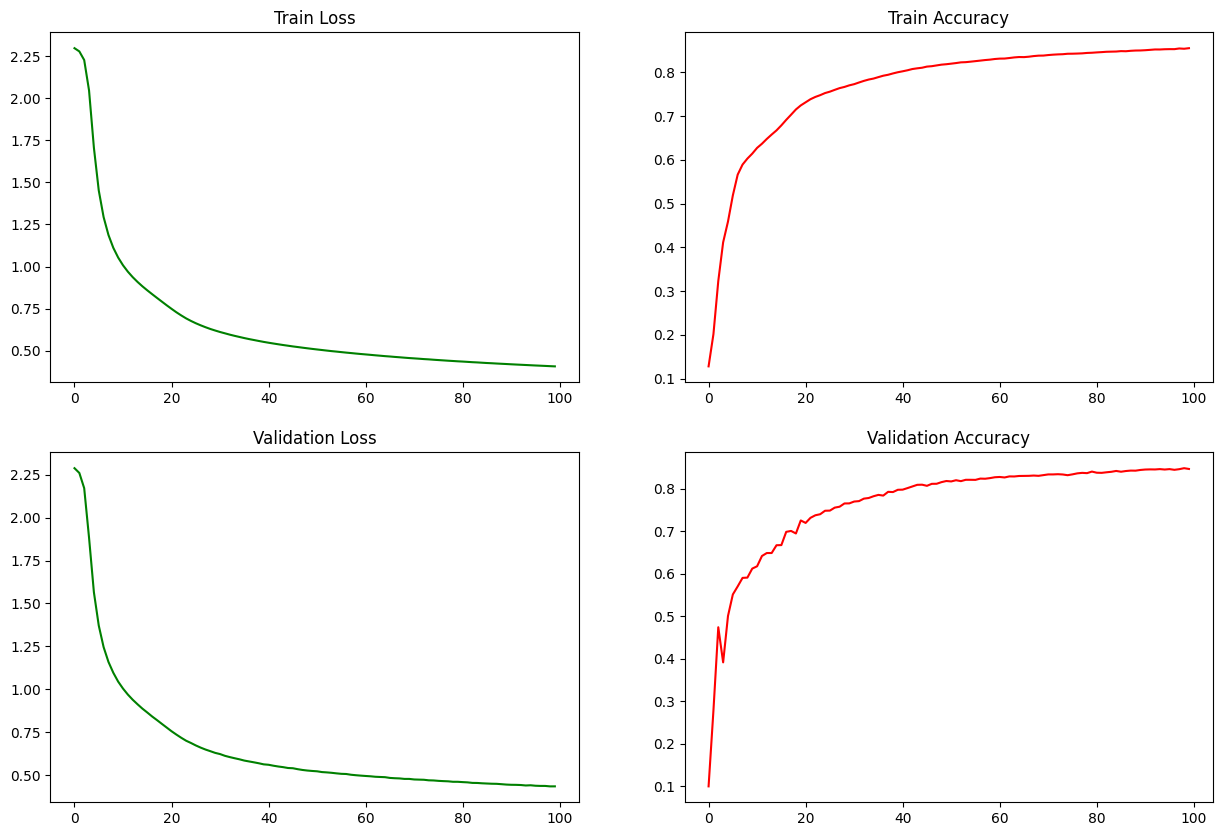

In [9]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Layer1_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Layer1_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Layer1_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Layer1_Validation Accuracy')

### Train mô hình với lớp thứ 2

In [10]:
for param in First.parameters():
    param.requires_grad = False

model = nn.Sequential(
    First,
    Second,
    nn.Linear(output_dims, num_classes)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0)

In [11]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 2.3021, Train_Acc : 0.1103, Validation Loss : 2.2994, Val_Acc :0.1020
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 2.2950, Train_Acc : 0.1314, Validation Loss : 2.2939, Val_Acc :0.1022
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 2.2846, Train_Acc : 0.1748, Validation Loss : 2.2750, Val_Acc :0.1888
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 2.2628, Train_Acc : 0.2388, Validation Loss : 2.2441, Val_Acc :0.3032
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 2.2041, Train_Acc : 0.2879, Validation Loss : 2.1487, Val_Acc :0.3430
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 2.0409, Train_Acc : 0.3326, Validation Loss : 1.9197, Val_Acc :0.3035
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 1.8028, Train_Acc : 0.4164, Validation

Text(0.5, 1.0, 'Validation Accuracy')

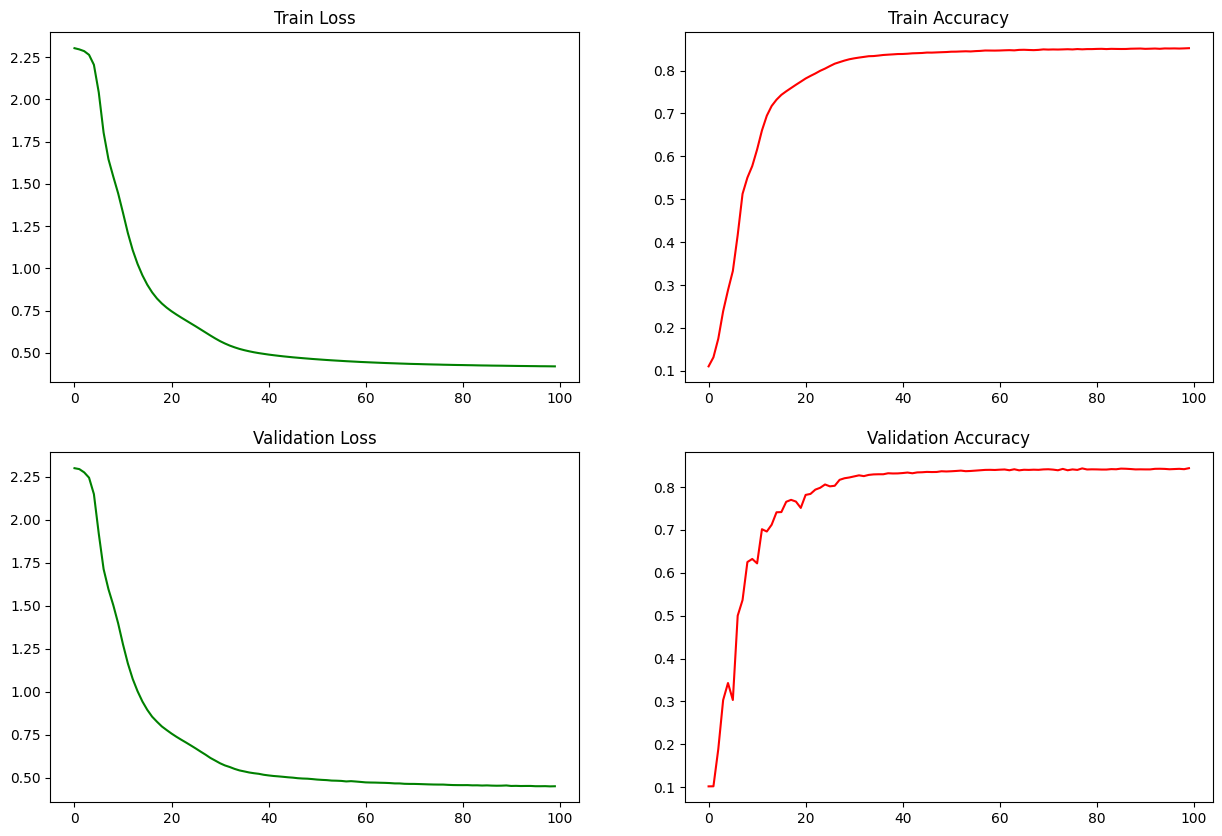

In [12]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Layer2_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Layer2_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Layer2_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Layer2_Validation Accuracy')

### Train mô hình với lớp thứ 3

In [13]:
for param in First.parameters():
    param.requires_grad = False
for param in Second.parameters():
    param.requires_grad = False

model = nn.Sequential(
    First,
    Second,
    Third,
    nn.Linear(output_dims, num_classes)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0)

In [14]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 2.3031, Train_Acc : 0.1074, Validation Loss : 2.2994, Val_Acc :0.1022
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 2.2958, Train_Acc : 0.1272, Validation Loss : 2.2908, Val_Acc :0.2000
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 2.2854, Train_Acc : 0.1700, Validation Loss : 2.2776, Val_Acc :0.1137
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 2.2623, Train_Acc : 0.2207, Validation Loss : 2.2422, Val_Acc :0.2870
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 2.1978, Train_Acc : 0.2532, Validation Loss : 2.1367, Val_Acc :0.1912
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 2.0233, Train_Acc : 0.2985, Validation Loss : 1.8992, Val_Acc :0.2972
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 1.7895, Train_Acc : 0.3809, Validation

Text(0.5, 1.0, 'Validation Accuracy')

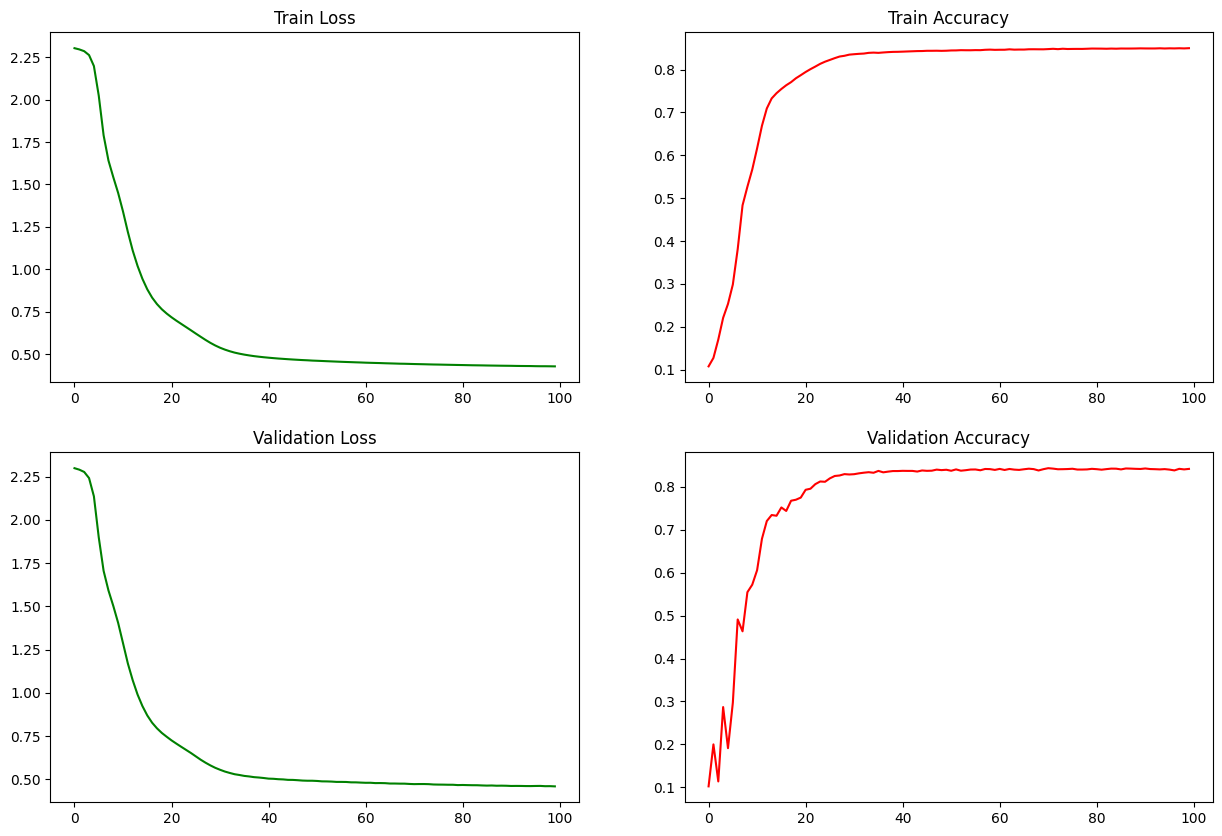

In [15]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Layer3_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Layer3_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Layer3_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Layer3_Validation Accuracy')

### Train mô hình với lớp thứ 4

In [8]:
for param in First.parameters():
    param.requires_grad = False
for param in Second.parameters():
    param.requires_grad = False
for param in Third.parameters():
    param.requires_grad = False

model = nn.Sequential(
    First,
    Second,
    Third,
    Forth,
    nn.Linear(output_dims, num_classes)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0)

In [ ]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


Text(0.5, 1.0, 'Validation Accuracy')

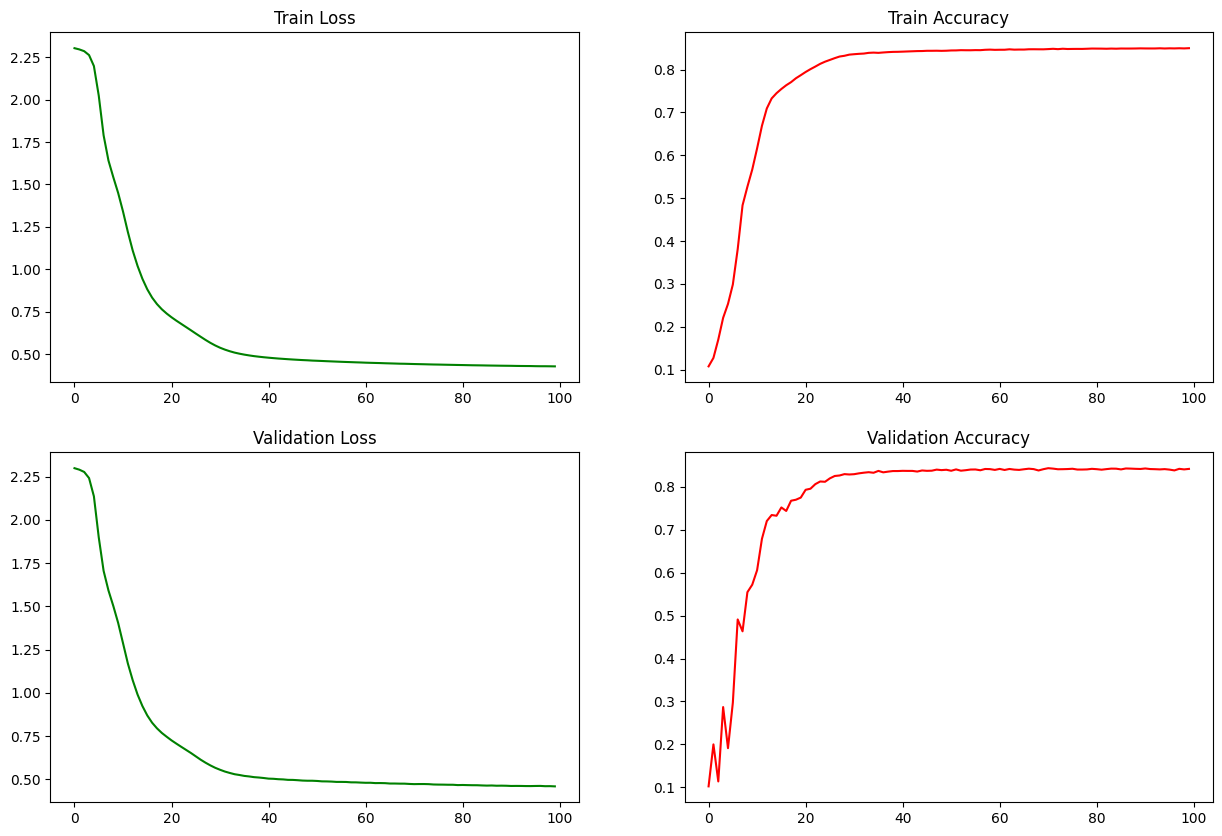

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Layer4_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Layer4_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Layer4_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Layer4_Validation Accuracy')

## Gradient normalization

In [11]:
   
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: pass input unchanged
        ctx.save_for_backward(input)  # Lưu input để sử dụng trong backward
        return input
    
    @staticmethod
    def backward(ctx, grad_output):
        # normalize the gradient
        mean = torch.mean(grad_output)
        std = torch.std(grad_output, dim=1, keepdim=True)
        grad_input = (grad_output - mean)/(std + 1e-6)
        return grad_input
    
class GradientNormalizationlayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationlayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)


In [12]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, num_classes):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, num_classes)
    self.grad_normal1 = GradientNormalizationlayer()
    self.grad_normal2 = GradientNormalizationlayer()
    self.grad_normal3 = GradientNormalizationlayer()
    self.grad_normal4 = GradientNormalizationlayer()
    self.grad_normal5 = GradientNormalizationlayer()
    self.grad_normal6 = GradientNormalizationlayer()
    self.grad_normal7 = GradientNormalizationlayer()

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.05)
        nn.init.constant_(module.bias, 0.0)


  def forward(self, x):
    x = x.view(x.size(0), -1) # dùng để flatten mô hình
    # Using sigmoid
    x = self.layer1(x)
    x = self.grad_normal1(x)
    x = nn.Sigmoid()(x)

    x = self.layer2(x)
    x = self.grad_normal2(x)
    x = nn.Sigmoid()(x)

    x = self.layer3(x)
    x = self.grad_normal3(x)
    x = nn.Sigmoid()(x)

    x = self.layer4(x)
    x = self.grad_normal4(x)
    x = nn.Sigmoid()(x)

    x = self.layer5(x)
    x = self.grad_normal5(x)
    x = nn.Sigmoid()(x)

    x = self.layer6(x)
    x = self.grad_normal6(x)
    x = nn.Sigmoid()(x)

    x = self.layer7(x)
    x = self.grad_normal7(x)
    x = nn.Sigmoid()(x)
    
    out = self.output(x)
    return out


input_dims = 28*28
hidden_dims = 128
num_classes = 10
lr = 1e-3
num_epochs = 10
model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0)

In [13]:
epochs = 100
train_accs_lst, train_losses_lst = [],[]
val_accs_lst, val_losses_lst = [],[]

model.train()

for epoch in range(epochs):
  train_loss = 0
  train_accs = 0
  count = 0

  model.train()
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    train_accs += (predicted == y_train).sum().item()
    count += y_train.size(0)
  
  train_loss /= len(train_loader)
  train_accs /= count
  train_losses_lst.append(train_loss)
  train_accs_lst.append(train_accs)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_accs = 0
    count = 0

    for x_val, y_val in val_Loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      outputs = model(x_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      val_accs += (predicted == y_val).sum().item()
      count += y_val.size(0)

    val_loss /= len(val_Loader)
    val_accs /= count
    val_losses_lst.append(val_loss)
    val_accs_lst.append(val_accs)

    print(f"EPOCH {epoch +1}/{epochs}, Train_Loss : {train_loss:.4f}, Train_Acc : {train_accs:.4f}, Validation Loss : {val_loss:.4f}, Val_Acc :{val_accs:.4f}")
    print('-'*59)


EPOCH 1/100, Train_Loss : 2.3128, Train_Acc : 0.1004, Validation Loss : 2.3027, Val_Acc :0.0997
-----------------------------------------------------------
EPOCH 2/100, Train_Loss : 2.3030, Train_Acc : 0.0985, Validation Loss : 2.3040, Val_Acc :0.0895
-----------------------------------------------------------
EPOCH 3/100, Train_Loss : 2.3029, Train_Acc : 0.0991, Validation Loss : 2.3031, Val_Acc :0.0937
-----------------------------------------------------------
EPOCH 4/100, Train_Loss : 2.3029, Train_Acc : 0.0981, Validation Loss : 2.3029, Val_Acc :0.1022
-----------------------------------------------------------
EPOCH 5/100, Train_Loss : 2.3029, Train_Acc : 0.0964, Validation Loss : 2.3032, Val_Acc :0.1022
-----------------------------------------------------------
EPOCH 6/100, Train_Loss : 2.3028, Train_Acc : 0.1004, Validation Loss : 2.3031, Val_Acc :0.0895
-----------------------------------------------------------
EPOCH 7/100, Train_Loss : 2.3029, Train_Acc : 0.0988, Validation

Text(0.5, 1.0, 'Gradient_norm_Validation Accuracy')

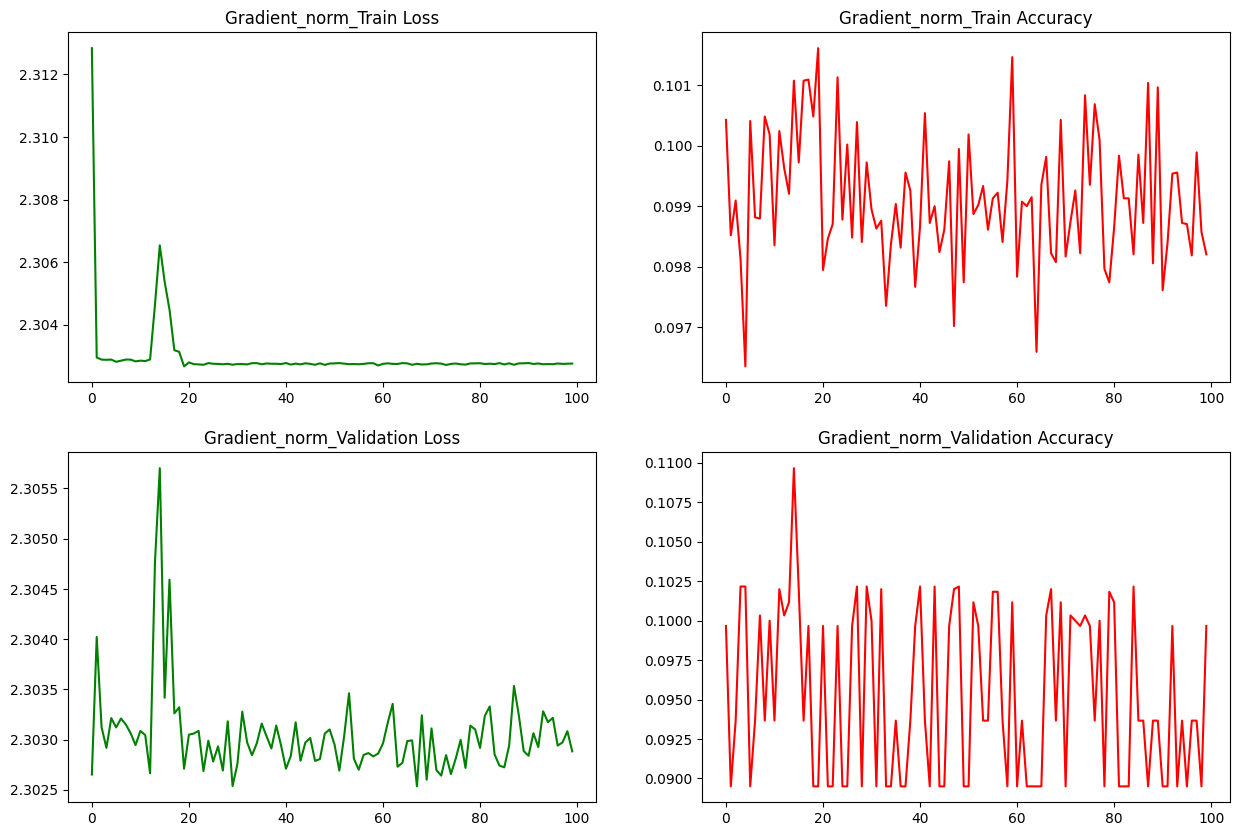

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(train_losses_lst, color = 'green')
ax[0,0].set_title('Gradient_norm_Train Loss')

ax[0,1].plot(train_accs_lst, color = 'red')
ax[0,1].set_title('Gradient_norm_Train Accuracy')

ax[1,0].plot(val_losses_lst, color = 'green')
ax[1,0].set_title('Gradient_norm_Validation Loss')

ax[1,1].plot(val_accs_lst, color = 'red')
ax[1,1].set_title('Gradient_norm_Validation Accuracy')